In [295]:
import pandas as pd
import numpy as np
import hashlib
from sklearn import tree
from matplotlib import pyplot as plt
from sklearn.tree import plot_tree
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_recall_curve, classification_report, precision_score, recall_score
import seaborn as sns
from IPython.display import SVG
from graphviz import Source
from IPython.display import display
from IPython.display import HTML
style = "<style>svg{width: 70% !important; height: 80% !important;} </style>"
HTML(style)

### Обезличивание и загрузка данных

In [234]:
# Define a custom date parsing function
def parse_datetime(date_string):
    return pd.to_datetime(date_string, format='%d.%m.%Y %H:%M:%S')

In [235]:
%%time
df = pd.read_excel('ИсходныеДанные.xlsx', parse_dates=['ДатаЗаказа', 'ДатаПоследнегоСтатуса'], date_parser=parse_datetime)

# delete na rows
df = df.dropna()

# unfacing mobile phones
# df['user_code'] = df['Телефон'].apply(lambda x: hashlib.md5(str(x).encode()).hexdigest())
# df = df.drop(columns=['Телефон'])

# add delivery days
df['Days_Delivery'] = (df['ДатаПоследнегоСтатуса'] - df['ДатаЗаказа']).dt.days

# cut 15 days from data
df = df[df['ДатаЗаказа'] < (df.ДатаЗаказа.max() - pd.DateOffset(days=15))]

# leave only delivered less than 60 days and less 7 trying
df = df[(df['Days_Delivery'] <= 60) & (df['ПопыткиДоставки'] <= 7)]

# Covert departments to codes
# df['Department'] = df['Подразделение'].astype('category').cat.codes
df['Department'] = LabelEncoder().fit_transform(df['Подразделение'])

# add redeemed
df['redeemed'] = df.Статус == 'Выкуплен'

# del document number
# df = df.drop(columns=['Номер'])

CPU times: total: 47.5 s
Wall time: 48.7 s


In [236]:
df

,Номер,ДатаЗаказа,Статус,ПопыткиДоставки,ДатаПоследнегоСтатуса,СуммаДокумента,Подразделение,Days_Delivery,Department,redeemed
0,DL00-037866,2022-01-03 18:21:58,Выкуплен,1.0,2022-01-06 19:31:42,8524.0,Владикавказ,3,7,True
1,DL00-037878,2022-01-03 18:37:55,Выкуплен,1.0,2022-01-06 10:33:27,6734.0,Казань,2,14,True
2,DL00-037885,2022-01-03 19:16:34,Выкуплен,1.0,2022-01-06 10:33:28,8524.0,Казань,2,14,True
3,DL00-037886,2022-01-03 19:16:36,Выкуплен,1.0,2022-01-06 10:33:27,2800.0,Казань,2,14,True
4,DL00-037942,2022-01-04 12:24:35,Не выкуплен,1.0,2022-01-14 13:13:02,3700.0,Иркутск,10,13,False
...,...,...,...,...,...,...,...,...,...,...
332361,DL00-335985,2023-06-11 15:11:56,Не выкуплен,1.0,2023-06-30 13:39:24,5034.0,Краснодар,18,18,False
332362,DL00-336003,2023-06-11 15:14:05,Выкуплен,1.0,2023-06-12 19:54:37,7300.0,Крым,1,20,True
332363,DL00-336042,2023-06-11 15:22:49,Выкуплен,1.0,2023-06-12 19:57:48,5500.0,Махачкала,1,24,True
332364,DL00-336056,2023-06-11 15:23:49,Выкуплен,1.0,2023-06-12 22:52:05,7838.0,Пятигорск,1,37,True


In [237]:
df['LabelEncoderDepartment'] = LabelEncoder().fit_transform(df['Подразделение'])

### Процент успешных доставок по количеству попыток доставки

In [238]:
success_percentage = df.groupby('ПопыткиДоставки')['redeemed'].mean()*100
success_percentage

ПопыткиДоставки
1.0    64.996308
2.0    66.171740
3.0    56.061115
4.0    48.258706
5.0    43.353474
6.0    38.436482
7.0    34.959350
Name: redeemed, dtype: float64

<AxesSubplot: xlabel='ПопыткиДоставки'>

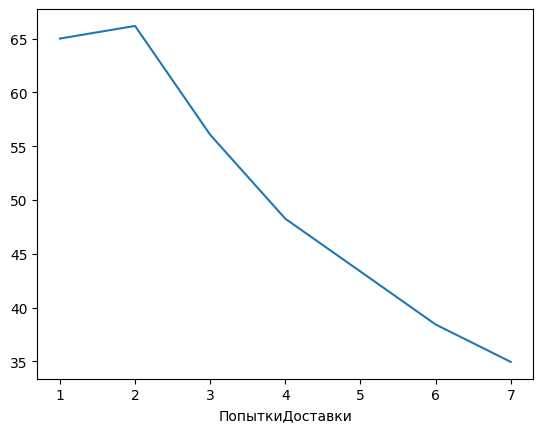

In [239]:
success_percentage.plot()

### Процент успешных доставок по количеству дней доставки

In [240]:
success_percentage = df.groupby('Days_Delivery')['redeemed'].mean()*100
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(success_percentage)

Days_Delivery
0     80.381091
1     82.451543
2     68.331816
3     62.286585
4     40.460310
5     32.114768
6     27.180952
7     18.614884
8     34.853831
9     13.087745
10    11.969904
11     7.825831
12    10.080183
13     8.923997
14     7.928731
15    21.731959
16    11.235955
17     8.557951
18     9.187859
19     9.335900
20     9.538462
21     7.494407
22    20.021645
23     8.708709
24     9.333333
25    10.371820
26     6.172840
27     5.854801
28     8.292683
29    24.349882
30     9.705882
31    10.032362
32     8.487085
33     7.037037
34     6.976744
35     5.339806
36    18.750000
37     6.081081
38    10.303030
39     0.847458
40     5.833333
41     5.511811
42     9.166667
43    13.223140
44     5.617978
45    10.769231
46    10.389610
47     3.030303
48    19.444444
49     3.703704
50    16.176471
51     4.761905
52    18.367347
53    13.636364
54    11.428571
55     4.347826
56    17.500000
57    22.500000
58     6.060606
59     9.677419
60    11.111111
Name: rede

<AxesSubplot: xlabel='Days_Delivery'>

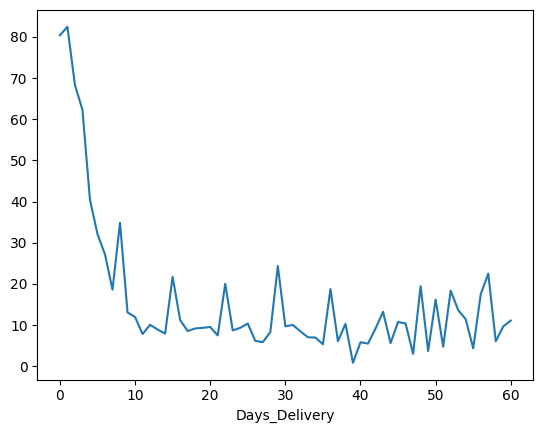

In [241]:
success_percentage.plot()

### Дерево решений

In [242]:
clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=13)
clf

DecisionTreeClassifier(criterion='entropy', max_depth=13)

In [243]:
X = df[['ПопыткиДоставки', 'Days_Delivery', 'Department']]
y = df.redeemed

In [244]:
clf.fit(X, y)

DecisionTreeClassifier(criterion='entropy', max_depth=13)

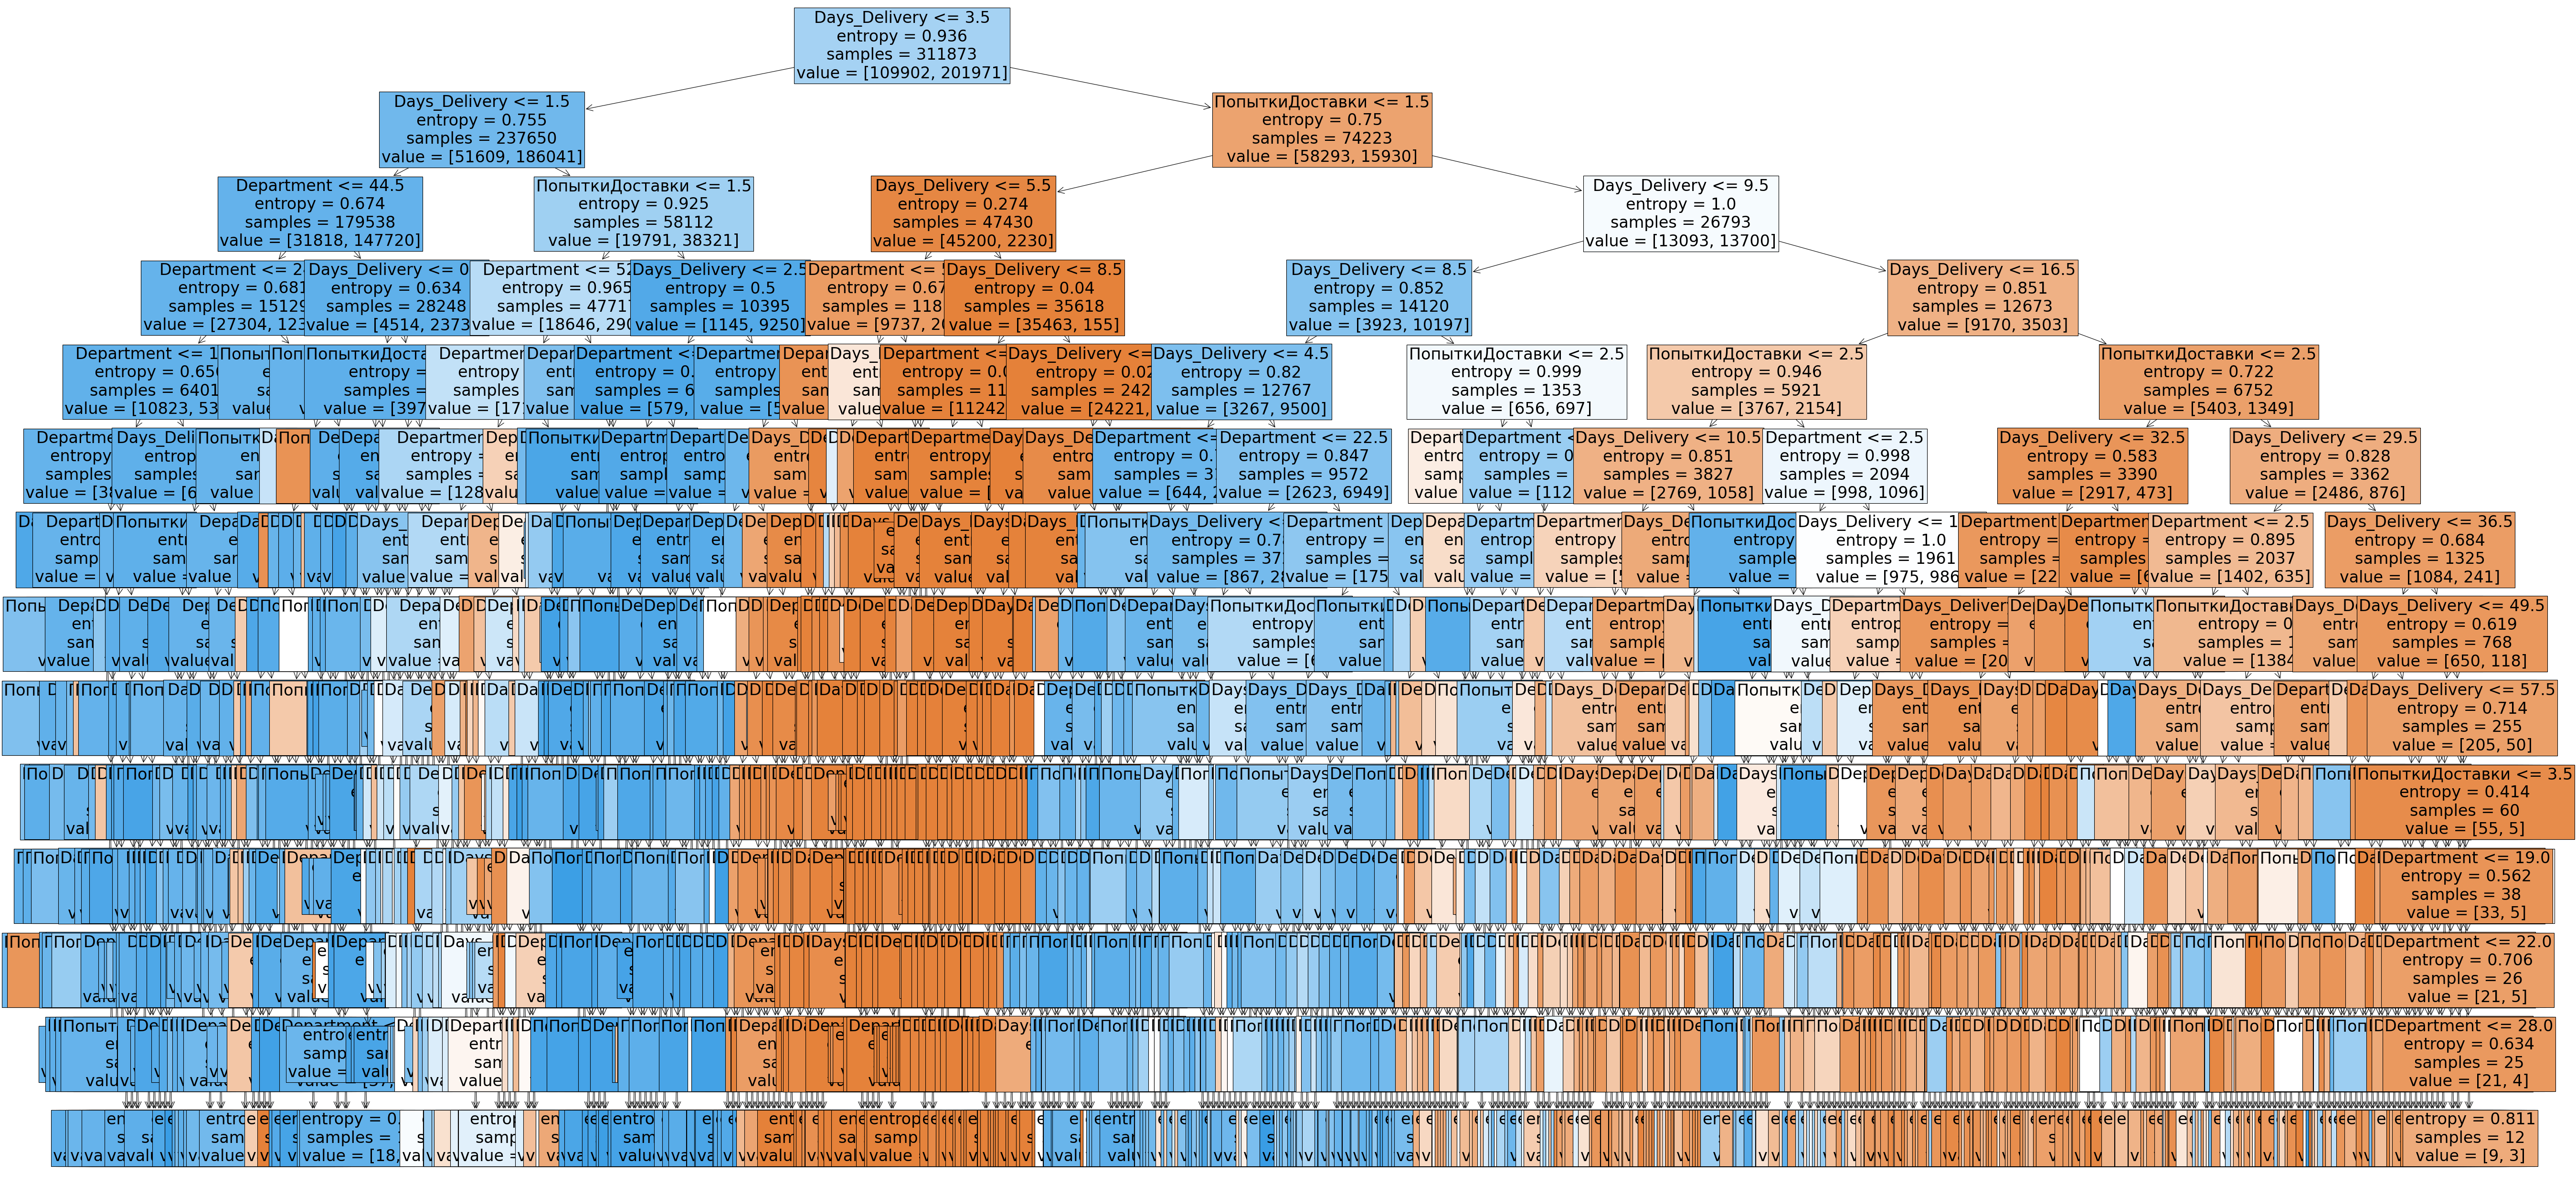

In [245]:
plt.figure(figsize=(80, 40),dpi=80)
p = tree.plot_tree(clf, fontsize=30,filled=True,feature_names=list(X))

In [246]:
clf.score(X, y)

0.8177655648292734

In [247]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.33, random_state=42)

In [248]:
clf.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=13)

In [249]:
clf.score(X_test, y_test)

0.8152624879759811

### Try getting as better values as possible

In [259]:
scores_data = pd.DataFrame()
for max_depth in range(1, 20):
    clf = tree.DecisionTreeClassifier(criterion='entropy', max_depth=max_depth)
    clf.fit(X_train, y_train)
    score_train = clf.score(X_train, y_train)
    score_test = clf.score(X_test, y_test)
    
    mean_cross_val_score = cross_val_score(clf, X_train, y_train, cv=5).mean()
    
    temp_scores_data = pd.DataFrame({'max_depth': [max_depth], 
                                     'score_train': [score_train], 
                                     'score_test': [score_test],
                                     'cross_val_score': [mean_cross_val_score]
                                    })
    scores_data = pd.concat([scores_data, temp_scores_data], ignore_index=True)

In [263]:
scores_data

,max_depth,score_train,score_test,cross_val_score
0,1,0.783010,0.784316,0.783010
1,2,0.785029,0.786113,0.785029
2,3,0.802827,0.804642,0.802727
3,4,0.802827,0.804642,0.802727
4,5,0.809298,0.810171,0.809102
5,6,0.809590,0.810531,0.809432
6,7,0.810791,0.812008,0.810035
7,8,0.812050,0.812921,0.810748
8,9,0.812844,0.812989,0.811447
9,10,0.813954,0.812590,0.812121


In [260]:
scores_data_long = pd.melt(scores_data, 
                           id_vars = ['max_depth'], 
                           value_vars = ['score_train','score_test', 'cross_val_score'], 
                           var_name = 'set_type', 
                           value_name = 'score')

In [261]:
scores_data_long[scores_data_long.set_type=='cross_val_score'].sort_values(by='score', ascending=False)

,max_depth,set_type,score
50,13,cross_val_score,0.813988
51,14,cross_val_score,0.813897
52,15,cross_val_score,0.813705
53,16,cross_val_score,0.813528
54,17,cross_val_score,0.813476
55,18,cross_val_score,0.813346
56,19,cross_val_score,0.813294
49,12,cross_val_score,0.812954
48,11,cross_val_score,0.812691
47,10,cross_val_score,0.812121


<AxesSubplot: xlabel='max_depth', ylabel='score'>

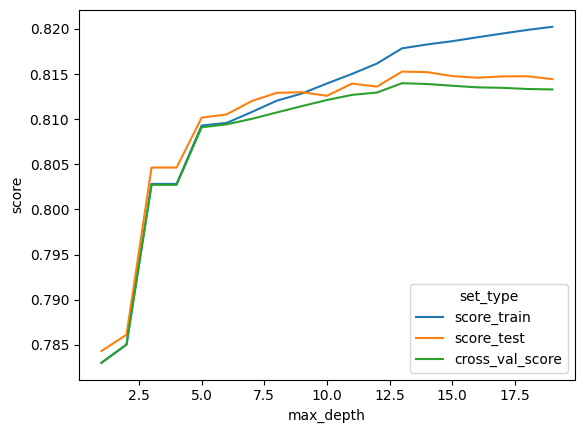

In [262]:
sns.lineplot(x='max_depth', y='score', hue='set_type', data=scores_data_long)

# GridSearchCV

In [264]:
clf = tree.DecisionTreeClassifier()
clf

DecisionTreeClassifier()

In [268]:
parameters = {'criterion':['gini', 'entropy'], 'max_depth': range(1,20)}

In [269]:
grid_search_cv_slf = GridSearchCV(clf, parameters, cv=5)

In [270]:
grid_search_cv_slf.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(1, 20)})

In [271]:
grid_search_cv_slf.best_params_

{'criterion': 'entropy', 'max_depth': 13}

In [274]:
best_clf = grid_search_cv_slf.best_estimator_

In [276]:
best_clf.score(X_test, y_test)

0.8152430552181813

In [282]:
report = classification_report(y_test, best_clf.predict(X_test), target_names=['Non-redeemed', 'redeemed'])
print(report)

              precision    recall  f1-score   support

Non-redeemed       0.88      0.55      0.68     36268
    redeemed       0.80      0.96      0.87     66651

    accuracy                           0.82    102919
   macro avg       0.84      0.76      0.77    102919
weighted avg       0.83      0.82      0.80    102919



In [284]:
y_pred = best_clf.predict(X_test)
y_pred

array([ True,  True,  True, ..., False,  True,  True])

In [285]:
y_pred_prob = best_clf.predict_proba(X_test)
y_pred_prob

array([[0.18757213, 0.81242787],
       [0.18757213, 0.81242787],
       [0.15294118, 0.84705882],
       ...,
       [0.90062112, 0.09937888],
       [0.31810193, 0.68189807],
       [0.20612775, 0.79387225]])

<AxesSubplot: >

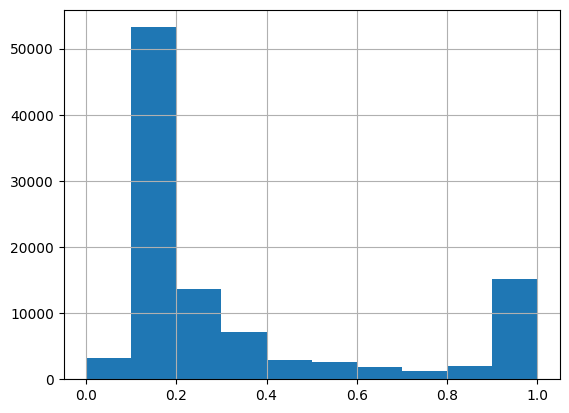

In [291]:
# Гистрограмма что будут доставлены
pd.Series(y_pred_prob[:, 0]).hist()

<AxesSubplot: >

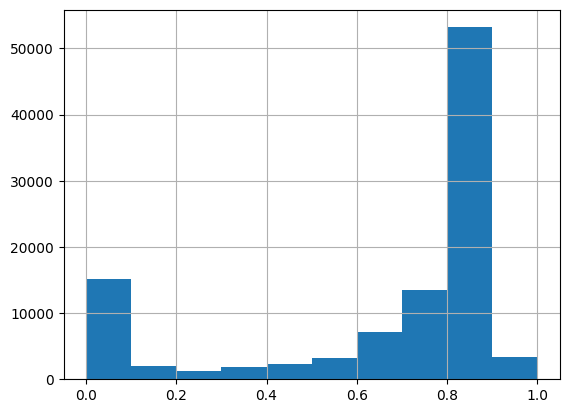

In [293]:
# Гистрограмма что НЕ будут доставлены
pd.Series(y_pred_prob[:, 1]).hist()

In [318]:
y_pred = np.where(y_pred_prob[:, 1]>0.8, 1, 0)
print('precision_score=' + str(precision_score(y_test, y_pred)))
print('recall_score=' + str(recall_score(y_test, y_pred)))

precision_score=0.8303088357901832
recall_score=0.7022700334578627


### ROC кривая

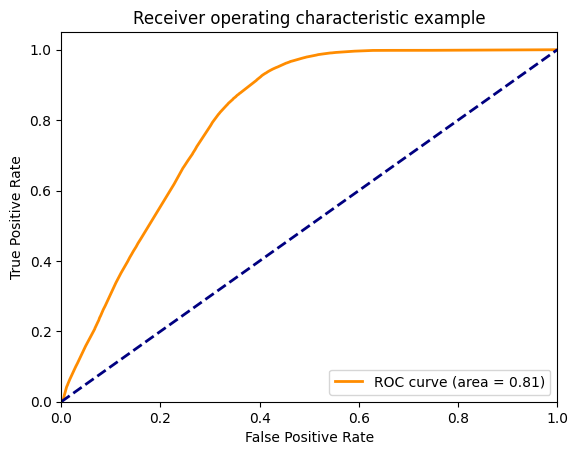

In [323]:
from sklearn.metrics import roc_curve, auc
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob[:,1])
lw = 2
roc_auc= auc(fpr, tpr)
plt.figure()
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()